In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph

In [41]:
class Value:
    def __init__(self,data, _children=(), _op=''):
        self.data = data
        self.grad = 0.0
        self._backwards = lambda: None
        self._prev = set(_children)
        self._op = _op
    
    def __repr__(self) -> str:
        return f"Value({self.data})"
    
    def __add__(self, other_value: 'Value'):
        out = Value(self.data + other_value.data, (self, other_value), '+')

        def _backwards():
            self.grad = 1.0 * out.grad
            other_value.grad = 1.0 * out.grad
        out._backwards = _backwards
        return out

    
    def __mul__(self, other_value: 'Value'):
        out = Value(self.data * other_value.data, (self, other_value), '*')

        def _backwards():
            self.grad = other_value.data * out.grad
            other_value.grad = self.data * out.grad
        out._backwards = _backwards 
        return out
    
    def tanh(self):
        x =self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')

        def _backwards():
            self.grad += (1-t**2) * out.grad
        out._backwards = _backwards
        return out
    
    def backward(self):
        self.grad = 1.0
        visited = set()
        def _backward(v: 'Value'):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    _backward(child)
                v._backwards()
        _backward(self)
        
        

In [42]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [43]:
# Building neural network
# inputs x1, x2
x1 = Value(2.0)
x2 = Value(0.0)
# weights w1, w2
w1 = Value(-3.0)
w2 = Value(1.0)
# bias
b = Value(6.8813735870195432)
type(b)

__main__.Value

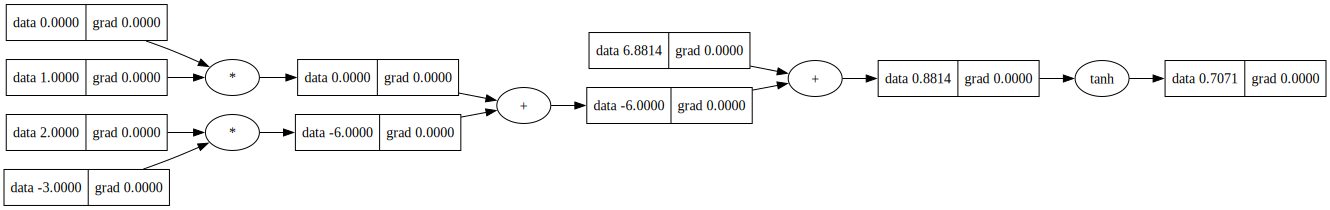

In [44]:

x1w1 = x1 * w1
x2w2 = x2 * w2
type(x1w1)
x1w1_x2w2 = x1w1 + x2w2
n = x1w1_x2w2 + b
o = n.tanh()
draw_dot(o)

In [32]:
o.grad = 1.0
n.grad = 1 - o.data**2
x1w1_x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1_x2w2.grad
x2w2.grad = x1w1_x2w2.grad
x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data


In [45]:
o.backward()

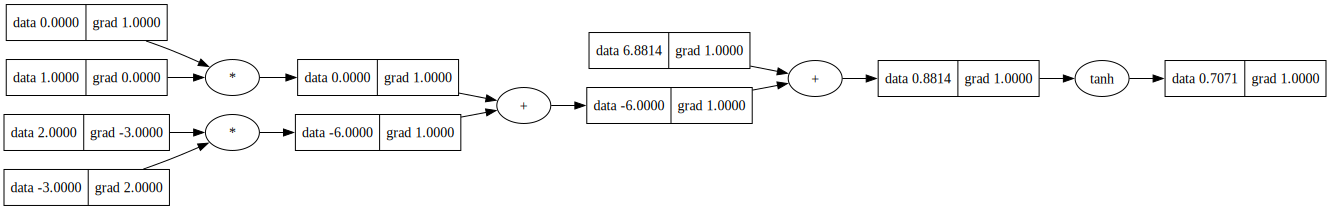

In [48]:
draw_dot(o)

In [ ]:
#  We see that increasing w2 will increase the output of the network

In [22]:
o.grad = 1.0

In [47]:
o._backwards()
n._backwards()
b._backwards()
x1w1_x2w2._backwards()
x1w1._backwards()
x2w2._backwards()
x1._backwards()
w1._backwards()
w2._backwards()
x2._backwards()

In [34]:
topo = []
def topological_sort(v):
    if v not in topo:
        for child in v._prev:
            topological_sort(child)
        topo.append(v)
topological_sort(o)
topo

[Value(1.0),
 Value(0.0),
 Value(0.0),
 Value(2.0),
 Value(-3.0),
 Value(-6.0),
 Value(-6.0),
 Value(6.881373587019543),
 Value(0.8813735870195432),
 Value(0.7071067811865476)]